This notebook is part of the $\omega radlib$ gists: https://wradlib.org/wradlib-gists.

Copyright (c) 2017, $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# HOWTO Plot radar data on a SRTM DEM map 

In [1]:
import wradlib as wrl
import matplotlib as mpl
import matplotlib.pyplot as pl
import warnings
import numpy as np
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

# Some more matplotlib tools we will need...
import matplotlib.ticker as ticker
from matplotlib.colors import SymLogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

## SRTM DEM plotting function

In [174]:
def plot_dem(srtmfile, ax, **kwargs):
    ds = wrl.io.open_raster(srtmfile)
    # pixel_spacing is in output units (lonlat)
    ds = wrl.georef.reproject_raster_dataset(ds, **kwargs)
    rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds)
    # specify kwargs for plotting, using terrain colormap and LogNorm
    dem = ax.pcolormesh(rastercoords[..., 0], rastercoords[..., 1],
                        rastervalues, norm=SymLogNorm(10),
                        cmap=pl.cm.terrain, vmin=0.5, vmax=3000,
                        zorder=-1)
    return dem, rastercoords

## River plotting function

In [144]:
def plot_rivers(ax, bbox):
    # plot rivers from esri vector shape, filter spatially
    # http://www.fao.org/geonetwork/srv/en/metadata.show?id=37331

    # open the input data source and get the layer
    filename = wrl.util.get_wradlib_data_file('geo/rivers_asia_37331.shp')
    dataset, inLayer = wrl.io.open_shape(filename)

    # do spatial filtering to get only geometries inside bounding box
    inLayer.SetSpatialFilterRect(bbox[0], bbox[1], bbox[2], bbox[3])
    rivers, keys = wrl.georef.get_shape_coordinates(inLayer, key='MAJ_NAME')

    # plot on ax1, and ax4
    wrl.vis.add_lines(ax, rivers, color=pl.cm.terrain(0.), lw=0.5, zorder=3)

## Radar Data plotting function

In [145]:
def plot_data(data, ax):
    
    x0 = data['site'][0]
    y0 = data['site'][1]
    ax, pm = wrl.vis.plot_ppi(np.ma.masked_less(data['data'], 0.1), 
                              r=data['r']*1000, az=data['azi'], 
                              elev=data['ele'],
                              proj=data['proj'], site=(x0, y0), 
                              fig=data['fig'], ax=ax,
                              cmap=pl.cm.plasma_r, vmin=0, vmax=data['data'].max())
    title = "{0} Radar Image {1} {2} \n long {3}E lat {4}N".format(data['sensorname'], data['date'], 
                                                                   data['time'], x0, y0)
    t = pl.title(title, fontsize=12)
    return pm

## Adding Colorbars

In [146]:
def add_colorbars(fig, ax, mappables, labels, ticks):
    div1 = make_axes_locatable(ax)
    cax = []
    pad = 0.1
    for ma in mappables:
        cax.append(div1.append_axes("right", size="5%", pad=pad))
        pad += 0.5
    for ma, ca, la, ti in zip(mappables, cax, labels, ticks):
        cbar = fig.colorbar(ma, cax=ca, ticks=ti)
        cbar.set_label(la)    

## Read Radar Data from Bengkulu Radar, Indonesia

Radar Bengkulu is a Selex-Gematronik, the data is in RAINBOW-Format.

In [147]:
def load_radar_data(radarfile, slice=0):
    rbdict = wrl.io.read_Rainbow(radarfile)

    # which slice to select from volume scan
    data=rbdict['volume']['scan']['slice'][slice]['slicedata']['rawdata']['data']

    # get azimuthal data
    azi = rbdict['volume']['scan']['slice'][slice]['slicedata']['rayinfo']['data']
    azidepth =  float(rbdict['volume']['scan']['slice'][slice]['slicedata']['rayinfo']['@depth'])
    azirange = float(rbdict['volume']['scan']['slice'][slice]['slicedata']['rayinfo']['@rays'])
    anglestep = float(rbdict['volume']['scan']['pargroup']['anglestep'])
    startangle = float(rbdict['volume']['scan']['slice'][0]['startangle'])
    stopangle = float(rbdict['volume']['scan']['slice'][0]['stopangle'])
    azi =  azi * azirange * anglestep / 2**azidepth
    offset = int(azi[0])
    azi = np.roll(azi, offset+1)
    data = np.roll(data, offset+1, axis=0)

     # create range array
    stoprange = float(rbdict['volume']['scan']['pargroup']['stoprange'])
    rangestep = float(rbdict['volume']['scan']['slice'][slice]['rangestep'])
    r = np.arange(0,stoprange,rangestep)

    # get elevation
    elevation = float(rbdict['volume']['scan']['slice'][0]['posangle'])

    unit = rbdict['volume']['scan']['slice'][slice]['slicedata']['rawdata']['@type']
    time = rbdict['volume']['scan']['slice'][slice]['slicedata']['@time']
    date = rbdict['volume']['scan']['slice'][slice]['slicedata']['@date']
    lon = float(rbdict['volume']['sensorinfo']['lon'])
    lat = float(rbdict['volume']['sensorinfo']['lat'])
    alt = float(rbdict['volume']['sensorinfo']['alt'])
    sensortype = rbdict['volume']['sensorinfo']['@type']
    sensorname = rbdict['volume']['sensorinfo']['@name']
    sitecoords = (lon, lat, alt) 
    datadict = {}
    datadict['data'] = data
    datadict['r'] = r
    datadict['rangestep'] = rangestep
    datadict['azi'] = azi
    datadict['ele'] = elevation
    datadict['site'] = sitecoords
    datadict['sensorname'] = sensorname
    datadict['date'] = date
    datadict['time'] = time
    datadict['unit'] = unit
    return datadict

In [148]:
radarfile = '2013080100020900dBZ.vol'
rbdict = load_radar_data(radarfile)

## Calculate Radar Bounding Box Limits 

In [149]:
coord = wrl.georef. sweep_centroids(len(rbdict['azi']), rbdict['rangestep']*1000, len(rbdict['r']), rbdict['ele'])
lon1, lat1, alt1 = wrl.georef.polar2lonlatalt_n(coord[..., 0], 
                                                np.degrees(coord[..., 1]),
                                                coord[..., 2], rbdict['site'])
rlimits = (lon1.min(), lat1.min(), lon1.max(), lat1.max())
print("Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f" %
      (lat1.max(), lon1.min(), lon1.max(), lat1.min()))

Radar bounding box:
	-2.78
101.26             103.42
	-4.94


## Create Projection

In [150]:
proj_wgs84 = wrl.georef.get_default_projection()
rbdict['proj'] = proj_wgs84

## Plot SRTM DEM

1000 1000


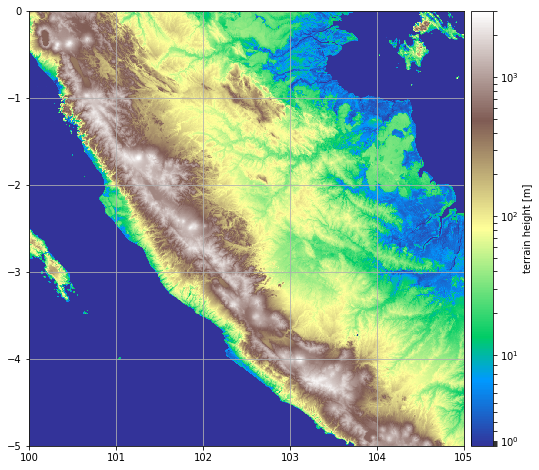

In [161]:
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111)
rbdict['fig'] = fig
srtmfile = '/automount/db01/python/data/DEM/tif/srtm_57_13.tif'
dem, dc = plot_dem(srtmfile, ax, spacing=0.005)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')
ax.grid(True)

# add colorbar
add_colorbars(fig, ax, [dem], ['terrain height [m]'], 
              [ticker.LogLocator(subs=range(10))])

pl.show()

## Plot SRTM DEM and Rivers

1000 1000


(-5.0, 0.0)

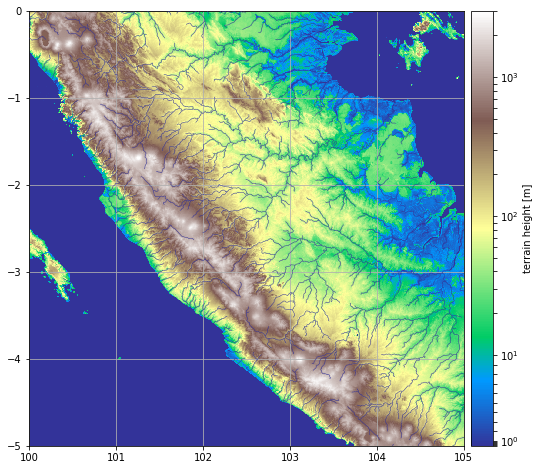

In [162]:
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111)

# add srtm
srtmfile = '/automount/db01/python/data/DEM/tif/srtm_57_13.tif'
dem, dc = plot_dem(srtmfile, ax, spacing=0.005)
ax.set_aspect('equal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True)

# add colorbar
add_colorbars(fig, ax, [dem], ['terrain height [m]'], 
              [ticker.LogLocator(subs=range(10))])

# add rivers
plot_rivers(ax, (dc[..., 0].min(), dc[..., 1].min(), dc[..., 0].max(), dc[..., 1].max()))
ax.set_xlim([dc[..., 0].min(), dc[..., 0].max()])
ax.set_ylim([dc[..., 1].min(), dc[..., 1].max()])

pl.show()

## Plot SRTM DEM, rivers and Radar Site

1000 1000


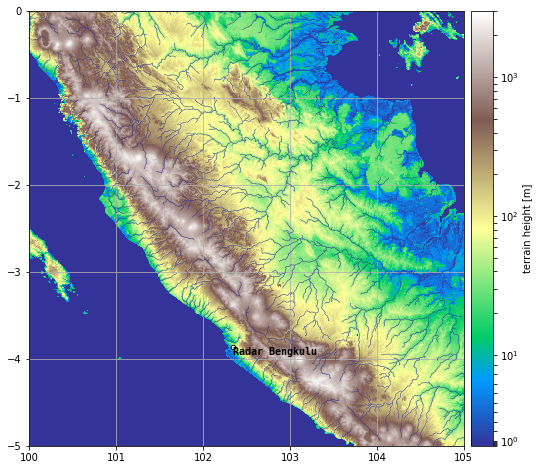

In [163]:
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111)

# add srtm
srtmfile = '/automount/db01/python/data/DEM/tif/srtm_57_13.tif'
dem, dc = plot_dem(srtmfile, ax, spacing=0.005)
ax.set_aspect('equal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True)

# add colorbar
add_colorbars(fig, ax, [dem], ['terrain height [m]'], 
              [ticker.LogLocator(subs=range(10))])

# add rivers
plot_rivers(ax, (dc[..., 0].min(), dc[..., 1].min(), dc[..., 0].max(), dc[..., 1].max()))
ax.set_xlim([dc[..., 0].min(), dc[..., 0].max()])
ax.set_ylim([dc[..., 1].min(), dc[..., 1].max()])

# add radar site
ax.scatter(rbdict['site'][0], rbdict['site'][1], 20, color="w", marker="o", edgecolor="k", zorder=2)
names = ["Radar Bengkulu"]
for i in range(len(names)):
    ax.text(rbdict['site'][0], rbdict['site'][1], names[i], va="top", family="monospace", weight="bold")
    
pl.show()

## Plot Radar Data on top of created map

1000 1000


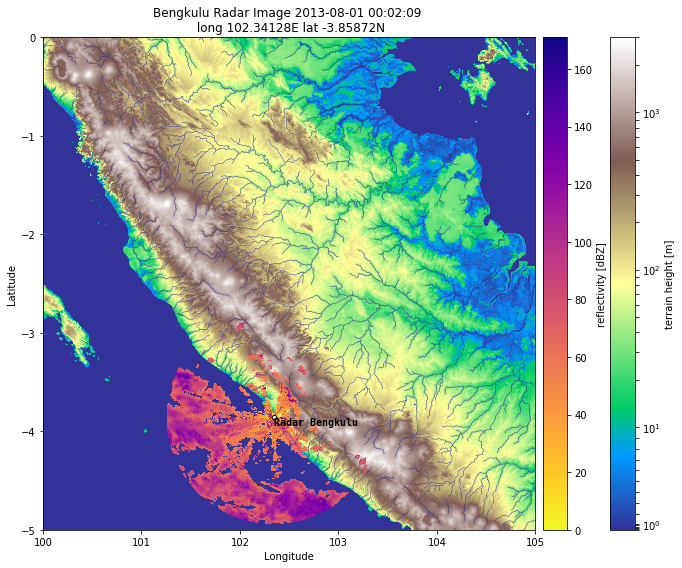

In [165]:
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111)
rbdict['fig'] = fig

# add srtm
srtmfile = '/automount/db01/python/data/DEM/tif/srtm_57_13.tif'
dem, dc = plot_dem(srtmfile, ax, spacing=0.005)
ax.set_aspect('equal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True)

# plot radar data
pm = plot_data(rbdict, ax)

# add colorbars
add_colorbars(fig, ax, [pm, dem], ['reflectivity [' + rbdict['unit'] + ']', 'terrain height [m]'], 
              [None, ticker.LogLocator(subs=range(10))])
# add rivers
plot_rivers(ax, (dc[..., 0].min(), dc[..., 1].min(), dc[..., 0].max(), dc[..., 1].max()))
ax.set_xlim([dc[..., 0].min(), dc[..., 0].max()])
ax.set_ylim([dc[..., 1].min(), dc[..., 1].max()])

# add radar site
ax.scatter(rbdict['site'][0], rbdict['site'][1], 20, color="w", marker="o", edgecolor="k", zorder=2)
names = ["Radar Bengkulu"]
for i in range(len(names)):
    ax.text(rbdict['site'][0], rbdict['site'][1], names[i], va="top", family="monospace", weight="bold")

    pl.tight_layout()
pl.show()

## Zoom into Radar Domain

1000 1000


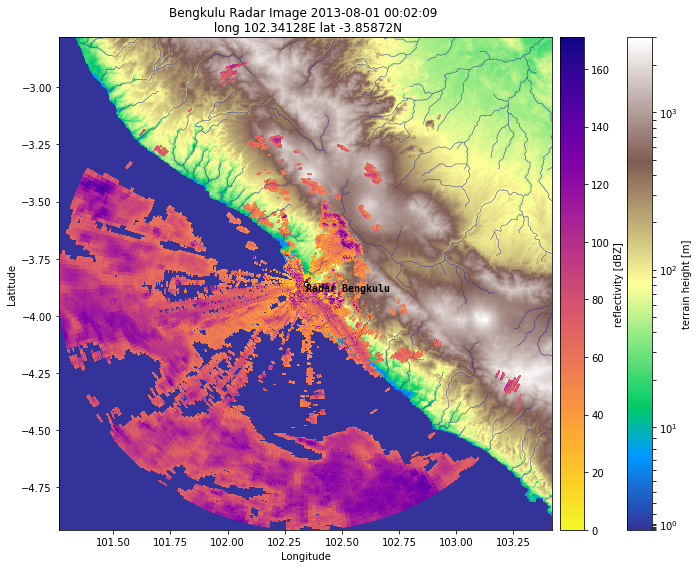

In [166]:
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111)
rbdict['fig'] = fig

# add srtm
srtmfile = '/automount/db01/python/data/DEM/tif/srtm_57_13.tif'
dem, dc = plot_dem(srtmfile, ax, spacing=0.005)
ax.set_aspect('equal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True)

# plot radar data
pm = plot_data(rbdict, ax)

# add colorbars
add_colorbars(fig, ax, [pm, dem], ['reflectivity [' + rbdict['unit'] + ']', 'terrain height [m]'], 
              [None, ticker.LogLocator(subs=range(10))])
# add rivers
plot_rivers(ax, (dc[..., 0].min(), dc[..., 1].min(), dc[..., 0].max(), dc[..., 1].max()))
ax.set_xlim([lon1.min(), lon1.max()])
ax.set_ylim([lat1.min(), lat1.max()])

# add radar site
ax.scatter(rbdict['site'][0], rbdict['site'][1], 20, color="w", marker="o", edgecolor="k", zorder=2)
names = ["Radar Bengkulu"]
for i in range(len(names)):
    ax.text(rbdict['site'][0], rbdict['site'][1], names[i], va="top", family="monospace", weight="bold")

pl.tight_layout()

pl.show()